In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm


In [11]:
df = pd.read_csv("cyberbullying.csv")

In [3]:
# Load model & tokenizer
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

c:\Users\genso\anaconda3\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\genso\.cache\huggingface\hub\models--unitary--toxic-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [12]:
# Toxicity labels used in this model
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store results
toxic_results = []

In [14]:
for text in tqdm(df["tweet_text"], desc="Scoring toxicity"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).squeeze().cpu().tolist()
    toxic_results.append(probs)

Scoring toxicity: 100%|██████████| 47692/47692 [26:48<00:00, 29.65it/s]  


In [15]:
tox_df = pd.DataFrame(toxic_results, columns=[f"tox_{l}" for l in labels])
df_final = pd.concat([df.reset_index(drop=True), tox_df], axis=1)

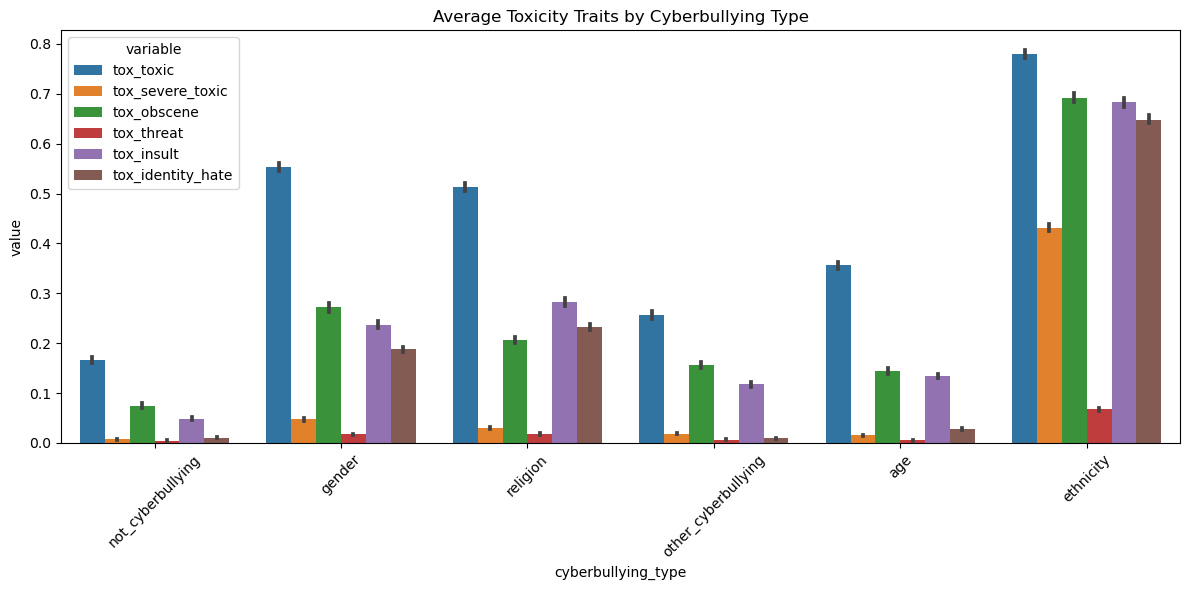

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

tox_cols = [col for col in df_final.columns if col.startswith("tox_")]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_final.melt(id_vars="cyberbullying_type", value_vars=tox_cols),
    x="cyberbullying_type", y="value", hue="variable"
)
plt.xticks(rotation=45)
plt.title("Average Toxicity Traits by Cyberbullying Type")
plt.tight_layout()
plt.show()